# TM10007 Assignment template

In [2]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [3]:
# Data loading functions. Uncomment the one you want to use
#from worcgist.load_data import load_data
from worclipo.load_data import load_data
#from worcliver.load_data import load_data
#from ecg.load_data import load_data

# Import classifiers
from sklearn import model_selection
from sklearn.model_selection import train_test_split, StratifiedKFold

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

X = data.drop("label",axis=1)
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    X_train_fold = X_train.iloc[train_idx]
    y_train_fold = y_train.iloc[train_idx]
    X_val_fold = X_train.iloc[val_idx]
    y_val_fold = y_train.iloc[val_idx]

    print(f"Fold {fold}:")
    print(f" - Train size: {len(X_train_fold)}")
    print(f" - Validation size: {len(X_val_fold)}")


The number of samples: 115
The number of columns: 494
Fold 1:
 - Train size: 73
 - Validation size: 19
Fold 2:
 - Train size: 73
 - Validation size: 19
Fold 3:
 - Train size: 74
 - Validation size: 18
Fold 4:
 - Train size: 74
 - Validation size: 18
Fold 5:
 - Train size: 74
 - Validation size: 18


General functions to be used

In [4]:
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn

# Classifiers
from sklearn import model_selection
from sklearn import metrics

# Some functions we will use
def colorplot(clf, ax, x, y, h=100, precomputer=None):
    '''
    Overlay the decision areas as colors in an axes.

    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    features = np.c_[xx.ravel(), yy.ravel()]
    if precomputer is not None:
        if type(precomputer) is RBFSampler:
            features = precomputer.transform(features)
        elif precomputer is rbf_kernel:
            features = rbf_kernel(features, X)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(features)
    else:
        Z = clf.predict_proba(features)
    if len(Z.shape) > 1:
        Z = Z[:, 1]

    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm

def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

### Preprocessing

Missing data
* Part 1: Finding missing data

In [5]:
# Define missing value indicators
custom_missing = ['NA', 'N/A', '?', 'None', 'none', '-']

# Count NaNs
nan_counts = X_train.isna().sum()

# Count empty strings
empty_string_counts = (X_train == '').sum()

# Count custom missing indicators (case-insensitive match)
custom_missing_counts = X_train.apply(lambda col: col.astype(str).str.lower().isin([val.lower() for val in custom_missing]).sum())

# Compute total missing count per column
total_missing = nan_counts + empty_string_counts + custom_missing_counts

# Filter out columns where total missing is zero
total_missing_selected = total_missing[total_missing != 0]

# Print total missing counts
print(total_missing_selected)

Series([], dtype: int64)


* Part 2: Processing missing data

In [6]:
# Import
import numpy as np
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro

# Replacing missing values with NaN
custom_missing = ['NA', 'N/A', '?', 'None', 'none', '-', '']
X_train.replace(custom_missing, np.nan, inplace=True)
X_test.replace(custom_missing, np.nan, inplace=True)

# If 50% or more of the data within one feature is missing the feature is deleted
limit = len(X_train.index)*50/100
valid_columns = [col for col, count in total_missing.items() if count < limit]

# Keep only the valid columns in both X_train and X_test
X_train = X_train[valid_columns]
X_test = X_test[valid_columns]

# Imputate

# Check if imputation is needed
if X_train.isna().sum().sum() == 0:
    pass
else:
    # Dictionary to store mean/median decision per column
    imputation_strategies = {}

    for col in X_train.select_dtypes(include=['number']).columns:  # Only numeric columns
        col_data = X_train[col].dropna()  # Remove NaN values for testing

        if len(col_data) > 3:  # Shapiro requires at least 3 non-null values
            if col_data.nunique() == 1:  # Check if all values are the same
                strategy = 'median'  # Default to median if no variability
            else:
                _, p = shapiro(col_data)
                strategy = 'mean' if p > 0.05 else 'median'
        else:
            strategy = 'median'  # Default to median if too few values

        imputation_strategies[col] = strategy

    # Create imputers for mean and median
    mean_imputer = SimpleImputer(strategy='mean')
    median_imputer = SimpleImputer(strategy='median')

    # Apply imputers for each feature
    for col, strategy in imputation_strategies.items():
        imputer = mean_imputer if strategy == 'mean' else median_imputer
        X_train[col] = imputer.fit_transform(X_train[[col]])
        X_test[col] = imputer.transform(X_test[[col]])  # Use the same imputer

Scaling data

In [7]:
import pandas as pd
from sklearn import preprocessing

scaler_robust = preprocessing.RobustScaler()

scaled_robust_array_train = scaler_robust.fit_transform(X_train)
scaled_robust_array_test = scaler_robust.transform(X_test)

X_scaled_robust_train = pd.DataFrame(scaled_robust_array_train, columns=X_train.columns)
X_scaled_robust_test = pd.DataFrame(scaled_robust_array_test, columns=X_test.columns)

print(X_scaled_robust_test)

    PREDICT_original_sf_compactness_avg_2.5D  \
0                                   0.896064   
1                                   0.616268   
2                                   0.175550   
3                                   0.857793   
4                                  -0.455090   
5                                  -0.180561   
6                                  -0.886215   
7                                   0.984786   
8                                   0.203404   
9                                   0.968292   
10                                 -0.692793   
11                                  0.895339   
12                                  0.627915   
13                                  0.332836   
14                                 -0.503299   
15                                  0.245738   
16                                 -0.522331   
17                                  0.617171   
18                                  0.664795   
19                                  0.21

### Feature extraction

Lloyd

Rfecv en svm

In [8]:
# Recursive Feature Elimination with Cross-Validation (RFECV)

# Import libraries
from sklearn import feature_selection
from sklearn import svm
import matplotlib.pyplot as plt

# calling the classifier (SVM model) for the feature selection
svc = svm.SVC(kernel="linear")

# RFECV feature selection and fitting
rfecv = feature_selection.RFECV(
    estimator=svc, step=5,
    cv=model_selection.StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

rfecv.fit(X_train, y_train)

# print selected feature names
selected_features = X_train.columns[sfs1.get_support()]
print("Selected features:", selected_features)

# plot the number of features vs. accuracy
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.show()

KeyboardInterrupt: 

Univariate testing (ANOVA) 

c:\Users\lloyd\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 76  77  85  90  96  97 103 109 110 422 423 435 436 441 448 449 467 474
 475 480 487 488] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\lloyd\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


(23, 100)
                                               Feature  F-Statistic   p-value
20                     PREDICT_original_sf_volume_2.5D    21.694039  0.000011
17                   PREDICT_original_sf_area_max_2.5D    15.131381  0.000192
19                   PREDICT_original_sf_area_std_2.5D    14.274434  0.000283
16                   PREDICT_original_sf_area_avg_2.5D    13.337932  0.000436
1             PREDICT_original_sf_compactness_std_2.5D    11.355724  0.001109
..                                                 ...          ...       ...
386        PREDICT_original_tf_Gabor_energy_F0.5_A0.79     2.811696  0.097050
484        PREDICT_original_phasef_phasesym_std_WL3_N5     2.786782  0.098520
104               PREDICT_original_tf_LBP_mean_R15_P36     2.734036  0.101715
279         PREDICT_original_tf_Gabor_peak_F0.05_A0.79     2.723322  0.102378
335  PREDICT_original_tf_Gabor_quartile_range_F0.2_...     2.713065  0.103017

[100 rows x 3 columns]


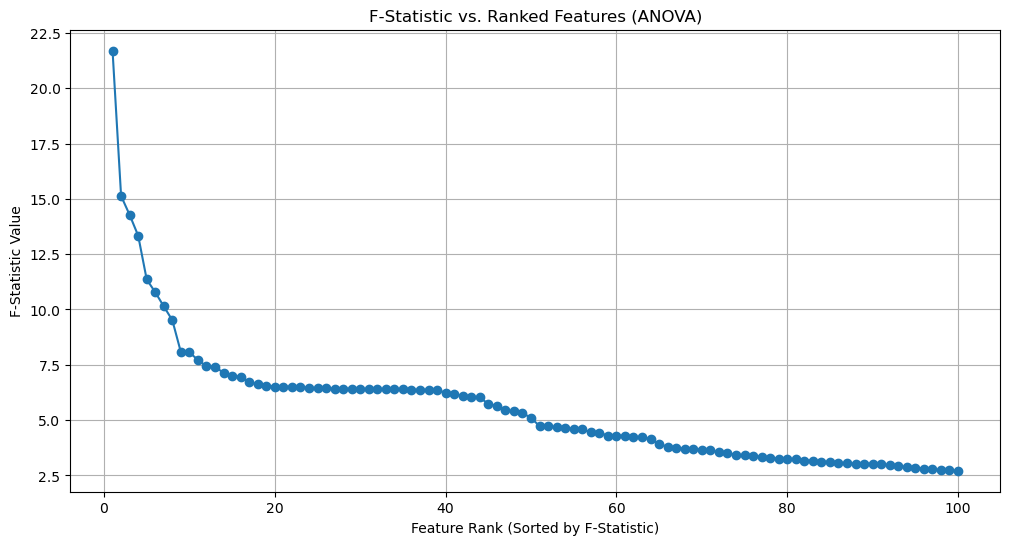

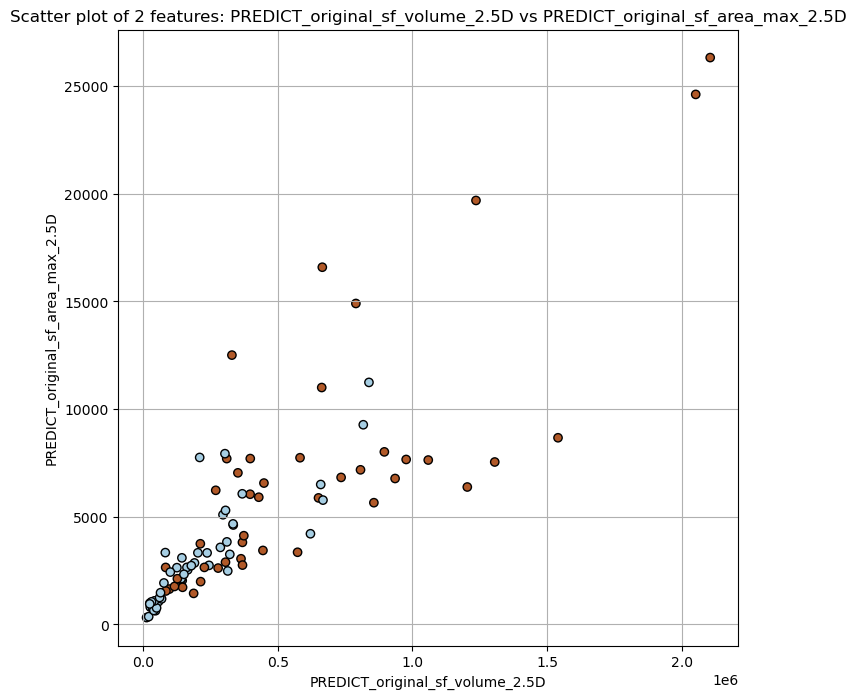

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# Zet de labels om naar numerieke waarden
le = LabelEncoder()
y_train_numeric = le.fit_transform(y_train)
legend_labels = le.classes_  # Toont de mapping van labels naar nummers

# ANOVA F-test (lineaire relaties)
selector_anova = SelectKBest(f_classif, k=100)
X_filtered_train_anova = selector_anova.fit_transform(X_scaled_robust_train, y_train)
anova_features = X_scaled_robust_train.columns[selector_anova.get_support()]
# create test feature set
X_filtered_test_anova = pd.DataFrame(selector_anova.transform(X_scaled_robust_test), columns=anova_features)
print(X_filtered_test_anova.shape)

f_values, p_values = selector_anova.scores_, selector_anova.pvalues_
# Create a DataFrame to display features with their corresponding F-statistics and p-values
anova_results = pd.DataFrame({'Feature': X_scaled_robust_train.columns,'F-Statistic': f_values, 'p-value': p_values})

# Sort by F-statistic (highest to lowest) to find the most statistically significant features
anova_results_sorted_by_F = anova_results.sort_values(by='F-Statistic', ascending=False)
anova_results_sorted_by_F = anova_results_sorted_by_F[anova_results_sorted_by_F['Feature'].isin(anova_features)]
print(anova_results_sorted_by_F)

# Plot de F-statistic per feature
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, len(anova_results_sorted_by_F) + 1), anova_results_sorted_by_F['F-Statistic'], marker='o')
plt.xlabel("Feature Rank (Sorted by F-Statistic)")
plt.ylabel("F-Statistic Value")
plt.title("F-Statistic vs. Ranked Features (ANOVA)")
plt.grid(True)
plt.show()

# Mutual Information (niet-lineaire relaties)
selector_mi = SelectKBest(mutual_info_classif, k=100)
X_filtered_mi = selector_mi.fit_transform(X_scaled_robust_train, y_train)
mi_features = X_scaled_robust_train.columns[selector_mi.get_support()]

# Gemeenschappelijke features
common_features = list(set(anova_features).intersection(set(mi_features)))

# Unieke features voor ANOVA en MI
unique_anova = list(set(anova_features) - set(mi_features))
unique_mi = list(set(mi_features) - set(anova_features))

example_features = anova_results_sorted_by_F.iloc[0:2]['Feature'].values
fig = plt.figure(figsize=(8,8))
plt.scatter(X_train[example_features[0]], X_train[example_features[1]], c=y_train_numeric, cmap=plt.cm.Paired, edgecolor='k')
plt.xlabel(example_features[0])
plt.ylabel(example_features[1])
plt.title(f"Scatter plot of 2 features: {example_features[0]} vs {example_features[1]}")
plt.grid(True)

plt.show()

Greedy feature selection, forward AFTER ANOVA

In [ ]:
%pip install mlxtend

# Greedy feature selection (forward)

# importing the models
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
import pandas as pd

# transform X_filtered_anova to a dataframe
X_filtered_anova = pd.DataFrame(X_filtered_anova, columns=anova_features)

# calling the classifier for the feature selction
# clf = LogisticRegression(random_state=42)
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=500, random_state=42),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "kNN": KNeighborsClassifier(n_neighbors=5)  # Je kunt het aantal neighbors aanpassen
}

# Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

# loop through classifiers
for name, clf in classifiers.items():
    print(f"Running SFS for {name}: ...")

    # Greedy forward selection and fitting (select 10 best features)
    sfs = SequentialFeatureSelector(clf, n_features_to_select=20, direction='forward', scoring='accuracy', cv=cv)
    sfs.fit(X_filtered_anova, y_train)

    # store results
    selected_features = list(X_filtered_anova.columns[sfs.get_support()])

    # transform dataset to only contain selected features
    X_train_selected = sfs.transform(X_filtered_anova)

    # train model on the selctd features
    clf.fit(X_train_selected, y_train)

    best_score = clf.score(X_train_selected, y_train)
    # gives mean accuracy of model with 20 selected features
    # sfs.get_metric_dict() got the accuracy of each feature selection step

    # results: dictionary with the performance of different classifiers
    results[name] = {
        "features": selected_features,
        "accuracy": best_score
    }

print(results)

# Vind de beste classifier
best_classifier = max(results, key=lambda x: results[x]["accuracy"])
best_features = results[best_classifier]["features"]
best_accuracy = results[best_classifier]["accuracy"]

# Print het resultaat
print("\nBest classifier:", best_classifier)
print("Best accuracy:", best_accuracy)
print("Selected features:", best_features)

Visualize features of SFS

In [ ]:
from venny4py.venny4py import venny4py
import matplotlib.pyplot as plt

set_features_SFS_logistic_regression = set(results['LogisticRegression']['features'])
set_features_SFS_LDA = set(results['LDA']['features'])
set_features_SFS_QDA = set(results['QDA']['features'])
set_features_SFS_kNN = set(results['kNN']['features'])

complete_feature_set_SFS = set_features_SFS_logistic_regression | set_features_SFS_LDA | set_features_SFS_QDA | set_features_SFS_kNN
print(len(complete_feature_set_SFS))

# Definieer de sets van geselecteerde features voor elke classifier
sets = {
    'LogisticRegression': set(results['LogisticRegression']['features']),
    'LDA': set(results['LDA']['features']),
    'QDA': set(results['QDA']['features']),
    'kNN': set(results['kNN']['features'])
}

# Genereer het Venn-diagram
venny4py(sets=sets)

# Toon het diagram
plt.title("Overeenkomsten en verschillen tussen geselecteerde features")
plt.show()

Apply RFECV/SFS after ANOVA selecting

In [ ]:
# Further Feature Selection with RFE

# import modules
from sklearn import feature_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn import svm

# calling the classifier (SVM model or linear regression) for the feature selection
svc = svm.SVC(kernel="linear")
# clf = LogisticRegression(max_iter=500, random_state=42)

cv = model_selection.StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# RFECV feature selection and fitting
rfecv_anova = feature_selection.RFECV(estimator=svc,
                                      step=5,
                                      cv=cv,
                                      scoring='roc_auc')

rfecv_mi = feature_selection.RFECV(estimator=svc,
                                   step=5,
                                   cv=cv,
                                   scoring='roc_auc')

rfecv_anova.fit(X_filtered_anova, y_train)
rfecv_mi.fit(X_filtered_mi, y_train)

In [ ]:
# print selected feature names and the number of features selected
selected_features_anova = anova_features[rfecv_anova.support_]
selected_features_mi = mi_features[rfecv_mi.support_]

print("Features selected with ANOVA and RFECV:", list(selected_features_anova))
print("Features selected with MI and RFECV::", list(selected_features_mi))

print("Number of features selected with ANOVA and RFECV:", sum(rfecv_anova.support_))
print("Number of features  selected with MI and RFECV:", sum(rfecv_mi.support_))

# plot the number of features vs. accuracy
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_anova.cv_results_["mean_test_score"]) + 1), rfecv_anova.cv_results_["mean_test_score"], label="ANOVA + RFECV", color="blue")
plt.plot(range(1, len(rfecv_mi.cv_results_["mean_test_score"]) + 1), rfecv_mi.cv_results_["mean_test_score"], label="MI + RFECV", color="red")
plt.legend()
plt.show()

Inge: Optimization based feature selection > Lasso 

Importing Libraries for Lasso Feature Selection

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA


Standardized scaling for Lasso Feature Selection

In [ ]:

def scaler_standardized (X_train, X_test):
    """
    Scales the original training and test datasets using standardization (zero mean, unit variance). 
    
    This function applies `StandardScaler` from `sklearn.preprocessing` to transform 
    `X_train` and `X_test`, which is necessary for Lasso feature selection and other 
    machine learning models that require standardized input.

    Returns:
        tuple: A tuple containing:
            - `X_scaled_standard_train` (pd.DataFrame): The standardized training dataset.
            - `X_scaled_standard_test` (pd.DataFrame): The standardized test dataset.
    
    Note:
        The function assumes `X_train` and `X_test` are already defined globally.
    """
    scaler_standard = preprocessing.StandardScaler()

    scaled_standard_array_train = scaler_standard.fit_transform(X_train)
    scaled_standard_array_test = scaler_standard.transform(X_test)

    X_scaled_standard_train = pd.DataFrame(scaled_standard_array_train, columns=X_train.columns)
    X_scaled_standard_test = pd.DataFrame(scaled_standard_array_test, columns=X_test.columns)
    
    return X_scaled_standard_train, X_scaled_standard_test


Encode the categorical y-labels to numerical values

In [ ]:

def y_numeric(y_train, y_test):
    """
    Encodes categorical labels from `y_train` and `y_test` into numeric values using `LabelEncoder`.

    This function applies `LabelEncoder` from `sklearn.preprocessing` to transform categorical target 
    labels into numerical format, which is essential for machine learning models that require numeric inputs.

    Args:
        y_train (pd.Series): The training labels.
        y_test (pd.Series): The test labels.

    Returns:
        tuple: A tuple containing:
            - `y_train_numeric` (numpy.ndarray): The transformed numeric labels for the training set.
            - `y_test_numeric` (numpy.ndarray): The transformed numeric labels for the test set.

    Prints:
        - A dictionary mapping numeric labels to their corresponding original class names.

    Note:
        The function assumes `y_train` and `y_test` contain categorical labels.
    """
    le = LabelEncoder()
    y_train_numeric = le.fit_transform(y_train)
    y_test_numeric = le.transform(y_test)

    # Store the mapping of labels
    legend_labels = le.classes_  # This saves the original class names
    print("Label Mapping:", {i: label for i, label in enumerate(legend_labels)})   
    
    return y_train_numeric, y_test_numeric


Optimization based feature selection: LASSO

In [ ]:
# X_scaled_standard_train = scaler_standardized (X_train, X_test) is this necessary?

def lasso_fs(X_scaled_standard_train):
    """
    Performs optimization based feature selection using Lasso regression.

    This function applies Lasso regression with automatic hyperparameter tuning 
    (via `LassoCV`) to identify the most important features from the standardized training data.
    It selects features by penalizing less important coefficients, setting some to zero.
    
    Args:
        X_scaled_standard_train (pd.DataFrame): 
            The standardized training dataset with numerical features.

    Returns:
        tuple: A tuple containing:
            - `X_train_selected` (np.ndarray): The reduced training dataset containing only selected features.
            - `X_test_selected` (np.ndarray): The reduced test dataset containing only selected features.
    
    Prints:
        - The best `alpha` value found through cross-validation.
        - The names of the selected features.

    Note:
        - This function assumes `y_train_numeric` is globally defined.
        - `SelectFromModel` is used to remove unimportant features based on the Lasso model.
    """
    # Define LassoCV with cross-validation
    n_alphas = 200
    alphas = np.logspace(-10, -1, n_alphas)# Testing alpha from 0.0001 to 10
    random_state = 42 #  Using int will produce the same results everytime, 42 is along 0 the most popular choice
    lasso_cv = LassoCV(cv=5, alphas=alphas, random_state=random_state, max_iter=10000)  # TODO: cv = 5 chosen, what do we want?

    # Fit LassoCV on training data
    lasso_cv.fit(X_scaled_standard_train, y_train_numeric)

    # Get the best alpha value
    best_alpha = lasso_cv.alpha_

    # Train final Lasso model with optimal alpha
    lasso = Lasso(alpha=best_alpha, fit_intercept=False)
    lasso.fit(X_scaled_standard_train, y_train_numeric)

    # Select features
    selector = SelectFromModel(lasso, prefit=True)
    X_train_selected = selector.transform(X_scaled_standard_train)
    X_test_selected = selector.transform(X_scaled_standard_train)

    # Get selected feature indices and names
    selected_features = np.where(selector.get_support())[0]
    selected_feature_names = X_scaled_standard_train.columns[selected_features]
    n_features = len(selected_features)
    
    return best_alpha, X_train_selected, X_test_selected, selected_feature_names, n_features

# Capture the return values when calling the function
best_alpha, X_train_sel, X_test_sel, selected_feature_names, n_features = lasso_fs(X_scaled_standard_train)

# Print the captured values in the global scope
print(f"Best alpha found: {best_alpha}")
print("Selected Features:", selected_feature_names)
print(f"N features found: {n_features}")



PCA feature extraction

In [ ]:
best_alpha, X_train_sel, X_test_sel, selected_feature_names, n_features = lasso_fs(X_scaled_standard_train)

def PCA_fs(X_scaled_robust_train, X_scaled_robust_test, n_features):
    """
    Performs Principal Component Analysis (PCA) for feature reduction.

    This function applies PCA to reduce the dimensionality of the input data, 
    transforming the training and test datasets to a lower number of features 
    (specified by `n_features`), while retaining as much variance as possible.

    Args:
        n_features (int): 
            The number of principal components to retain after performing PCA.
            Based on the number of features of Lasso.

    Returns:
        tuple: A tuple containing:
            - `X_scaled_standard_train_PCA` (np.ndarray): The transformed training dataset with reduced features.
            - `X_scaled_standard_test_PCA` (np.ndarray): The transformed test dataset with reduced features.

    Notes:
        - The function assumes `X_scaled_robust_train` and `X_scaled_robust_test` are predefined globally.
        - The function applies the same transformation to both the training and test datasets, 
          ensuring that the test set is projected into the same lower-dimensional space as the training set.
    """
    pca = PCA(n_components=n_features)
    X_train_PCA = pca.fit_transform(X_scaled_robust_train)
    X_test_PCA = pca.transform(X_scaled_robust_test)  # Use the same transformation
    return X_train_PCA, X_test_PCA

# Assuming you already have the transformed PCA data
X_train_pca, X_test_pca = PCA_fs(X_scaled_robust_train, X_scaled_robust_test, n_features=7) 
best_alpha, X_train_sel, X_test_sel, selected_feature_names, n_features = lasso_fs(X_scaled_standard_train)

# Plotting the first two principal components of the training data
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_numeric)
plt.title('PCA - Training Data')
plt.xlabel(selected_feature_names[0])
plt.ylabel(selected_feature_names[1])
plt.show()

Testing feature selections 

In [ ]:
# General packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets as ds
from sklearn import metrics

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

# Zet de labels om naar numerieke waarden
le = LabelEncoder()
y_train = le.fit_transform(y_train)  # Zet 'lipoma' en 'liposarcoma' om naar 0 en 1
y_test = le.transform(y_test)  # Pas dezelfde transformatie toe op y_test

# Define the classifiers
classifiers = [
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    GaussianNB(),
    LogisticRegression(max_iter=5000),
    SGDClassifier(max_iter=5000, tol=1e-3),
    KNeighborsClassifier(n_neighbors=40),
    DecisionTreeClassifier(random_state=42)
]

# Store fitted classifiers
clfs_fit = []

# Select the same features for the test set
X_train_selected = X_filtered_anova  # Train-set met ANOVA-geselecteerde features
X_test_selected = selector_anova.transform(X_test)  # Test-set met ANOVA-features

# Train and evaluate classifiers
for clf in classifiers:
    # Train classifier
    clf.fit(X_scaled_robust_train, y_train)
    Y_pred = clf.predict(X_scaled_robust_test)

    # Store fitted classifier
    clfs_fit.append(clf)

    # Compute evaluation metrics
    accuracy = metrics.accuracy_score(y_test, Y_pred)

    if hasattr(clf, 'predict_proba'):
        y_score = clf.predict_proba(X_scaled_robust_test)[:, 1]  # Probability for class 1
    else:
        y_score = Y_pred  # Use binary predictions if probability is unavailable

    auc = metrics.roc_auc_score(y_test, y_score)
    f1 = metrics.f1_score(y_test, Y_pred)
    precision = metrics.precision_score(y_test, Y_pred)
    recall = metrics.recall_score(y_test, Y_pred)

    # Print the results
    print(f"Classifier: {clf.__class__.__name__}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  AUC: {auc:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print("-" * 50)

## Model selection
Random forest, decision tree and bagging

In [14]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

# Encode categorical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Define models and parameter distributions
models = {
    "Random Forest": (RandomForestClassifier(random_state=42), {
        'n_estimators': randint(5, 200),
        'max_depth': randint(3, 20),
        'min_samples_split': randint(5, 20),
        'bootstrap': [True, False]
    }),
    "Bagging": (BaggingClassifier(DecisionTreeClassifier(random_state=42), random_state=42), {
        'n_estimators': randint(5, 200),
        'estimator__max_depth': randint(3, 5),
        'estimator__min_samples_split': randint(5, 20),
        'bootstrap': [True, False]
    }),
    "Decision Tree": (DecisionTreeClassifier(random_state=42), {
        'max_depth': randint(3, 5),
        'min_samples_split': randint(5, 20)
    })
}

# Perform Randomized Search and store results
best_estimators = {}
best_params = {}
best_scores = {}

for name, (model, param_dist) in models.items():
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=30,
        scoring='accuracy',
        cv=10,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train_encoded) # Fitted on data without scaling and feature selection
    
    best_estimators[name] = search.best_estimator_
    best_params[name] = search.best_params_
    best_scores[name] = search.best_score_

# Print results
print("\n=== Model Comparison ===")
for model_name in models.keys():
    print(f"\nBest {model_name}: {best_estimators[model_name]}")
    print(f"Best {model_name} Parameters: {best_params[model_name]}")
    print(f"Best {model_name} Accuracy: {best_scores[model_name]:.4f}")



=== Model Comparison ===

Best Random Forest: RandomForestClassifier(bootstrap=False, max_depth=4, min_samples_split=16,
                       n_estimators=25, random_state=42)
Best Random Forest Parameters: {'bootstrap': False, 'max_depth': 4, 'min_samples_split': 16, 'n_estimators': 25}
Best Random Forest Accuracy: 0.7067

Best Bagging: BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                   min_samples_split=11,
                                                   random_state=42),
                  n_estimators=68, random_state=42)
Best Bagging Parameters: {'bootstrap': True, 'estimator__max_depth': 4, 'estimator__min_samples_split': 11, 'n_estimators': 68}
Best Bagging Accuracy: 0.6733

Best Decision Tree: DecisionTreeClassifier(max_depth=3, min_samples_split=5, random_state=42)
Best Decision Tree Parameters: {'max_depth': 3, 'min_samples_split': 5}
Best Decision Tree Accuracy: 0.6356


SVM

In [15]:
from sklearn.svm import SVC

# Define base SVM model
svm_model = SVC(random_state=42)

# Define parameter distribution for RandomizedSearchCV
param_dist = {
    'C': [0.1, 1, 10, 100, 1000],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.1, 1, 10, 100],  # Kernel coefficient
    'kernel': ['linear', 'rbf', 'poly'],  # Different kernel types
    'degree': [1, 2, 3, 4, 5, 6],  # Only used for poly kernel
}

#TIJDELIJK TODO weghalen
X_small = X_scaled_robust_train.iloc[:, [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110]]  # First 10 features

# Randomized Search with cv=10
random_search = RandomizedSearchCV(
    estimator=svm_model,
    param_distributions=param_dist,
    n_iter=30,  # More iterations for better results
    scoring='accuracy',
    cv=10,  # 10-fold cross-validation
    n_jobs=-1,  # Use all CPU cores
    random_state=42
)

# Fit on robustly scaled training data
random_search.fit(X_small, y_train_encoded) #TODO data nog veranderen

# Get the best model and parameters
best_svm = random_search.best_estimator_
best_params_svm = random_search.best_params_
best_score_svm = random_search.best_score_

# Print results
print("\n=== Best SVM Model After Randomized Search ===")
print(f"Best SVM: {best_svm}")
print(f"Best SVM Parameters: {best_params_svm}")
print(f"Best SVM Accuracy: {best_score_svm:.4f}")



=== Best SVM Model After Randomized Search ===
Best SVM: SVC(C=10, degree=5, gamma=1, kernel='linear', random_state=42)
Best SVM Parameters: {'kernel': 'linear', 'gamma': 1, 'degree': 5, 'C': 10}
Best SVM Accuracy: 0.6333


kNN

In [ ]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

# Define base kNN model
knn_model = KNeighborsClassifier()

# Define parameter distribution for RandomizedSearchCV
param_dist_knn = {
    'n_neighbors': randint(3, 50),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#TIJDELIJK TODO weghalen
X_knn = X_scaled_robust_train.iloc[:, [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110]]  # Zelfde subset als bij SVM

random_search_knn = RandomizedSearchCV(
    estimator=knn_model,
    param_distributions=param_dist_knn,
    n_iter=30,
    scoring='accuracy',
    cv=cv_strategy,  
    n_jobs=-1,
    random_state=42
)

# Fit op geschaalde data
random_search_knn.fit(X_knn, y_train_encoded) #TODO data nog veranderen

# Beste model, parameters, en score ophalen
best_knn = random_search_knn.best_estimator_
best_params_knn = random_search_knn.best_params_
best_score_knn = random_search_knn.best_score_

# Resultaten afdrukken
print("\n=== Best kNN Model After Randomized Search ===")
print(f"Best kNN: {best_knn}")
print(f"Best kNN Parameters: {best_params_knn}")
print(f"Best kNN Accuracy: {best_score_knn:.4f}")



=== Best kNN Model After Randomized Search ===
Best kNN: KNeighborsClassifier(n_neighbors=6)
Best kNN Parameters: {'n_neighbors': 6, 'p': 2, 'weights': 'uniform'}
Best kNN Accuracy: 0.5339


LDA, QDA and Logistic regression

## Learning curves

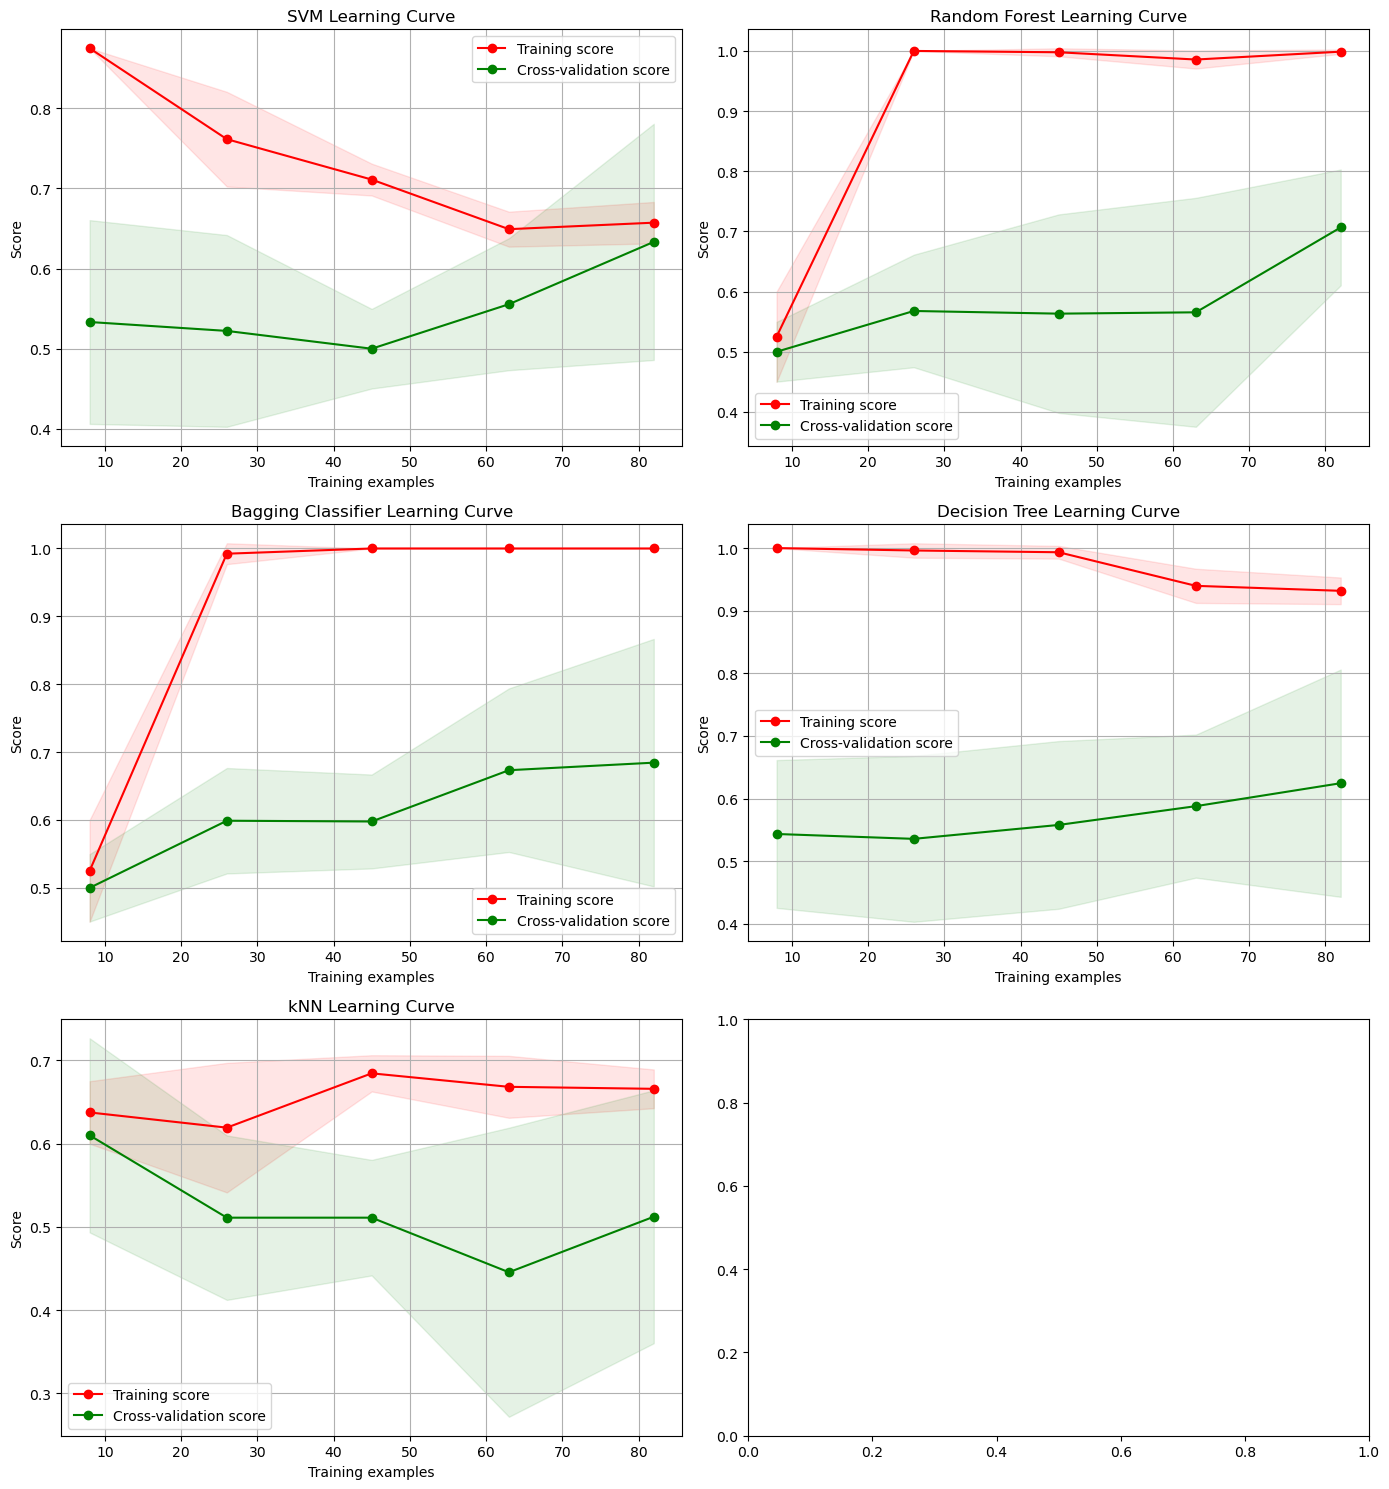

In [29]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Create subplots (2 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

# Plot learning curves for each best model
plot_learning_curve(best_svm, "SVM Learning Curve", X_small, y_train_encoded, axes[0, 0], cv=10)
plot_learning_curve(best_estimators["Random Forest"], "Random Forest Learning Curve", X_train, y_train_encoded, axes[0, 1], cv=10)
plot_learning_curve(best_estimators["Bagging"], "Bagging Classifier Learning Curve", X_train, y_train_encoded, axes[1, 0], cv=10)
plot_learning_curve(best_estimators["Decision Tree"], "Decision Tree Learning Curve", X_train, y_train_encoded, axes[1, 1], cv=10)
plot_learning_curve(best_knn, "kNN Learning Curve", X_knn, y_train_encoded, axes[2, 0], cv=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
